## Exploratory Data Anaylsis

File downloaded from:
https://www.kaggle.com/competitions/seti-breakthrough-listen/data/train/0/0000799a2b2c42d.npy

In [1]:
# !pip install plotly

In [2]:
import os
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir, path
import plotly.express as px

import cv2 as cv

Load training data.

In [3]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_df = pd.read_csv(os.path.join(data_dir, '_labels.csv'), delimiter=',')

# files = listdir(train_data_dir)

# for f in files:
#     train_data[f.split('.')[0]] = np.load(path.join(train_data_dir, f))

In [4]:
def get_image_path(data_directory, file_id):
    path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')

    return path

In [5]:
def get_image_data(data_directory, file_id):
    file_path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')
        
    if os.path.exists(file_path):
        return np.load(file_path)
    
    return

In [6]:
# train_labels = pd.read_csv(r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train\_labels.csv', delimiter=',')
# train_labels.head()

data_df = labels_df.copy()

# data_df['image_data'] = labels_df['id'].apply(lambda x: get_image_data(data_dir, x))
data_df['file_path'] = labels_df['id'].apply(lambda x: get_image_path(data_dir, x))

In [7]:
data_df.head()

,id,target,file_path
0,0000799a2b2c42d,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
1,00042890562ff68,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
2,0005364cdcb8e5b,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
3,0007a5a46901c56,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
4,0009283e145448e,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...


In [8]:
negative_samples = data_df.query('target == 0').sample(n=500)
positive_samples = data_df.query('target == 1').sample(n=500)

train_data_df = negative_samples.append(positive_samples)

C:\Users\adnan\AppData\Local\Temp\ipykernel_3576\1874693528.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_df = negative_samples.append(positive_samples)


Locate a positive sample so that it can be visualised:

In [15]:
positive_sample = train_data_df[train_data_df.target == 1].iloc[28]
positive_sample_images = np.load(positive_sample['file_path']).astype(np.float32)

It consists of a 3D array. Where there are 6 entries of images with resolution 273x256.

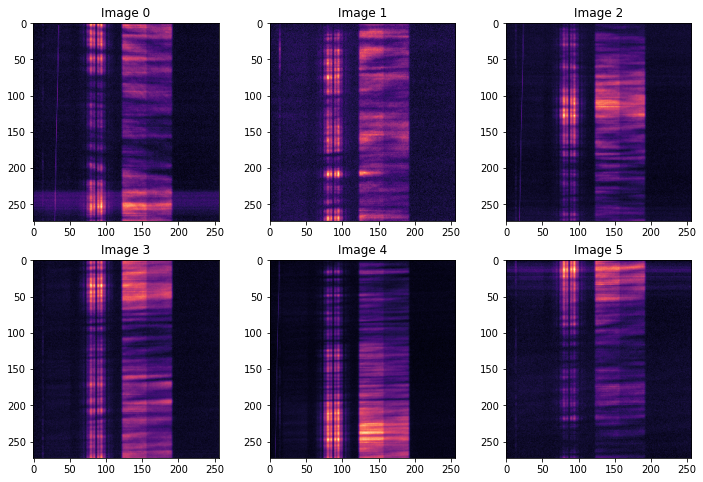

In [16]:
f, ax = plt.subplots(2, 3, figsize=(12,8))

for i in range(len(positive_sample_images)):
    row = i // 3
    column = i - row * 3
    
    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(positive_sample_images[i], cmap=plt.get_cmap('magma'))

Each data file is a collection of spectograms. There is one spectogram for each 6 stars observed in the sequence **ABACAD**.
Where A is the target star and the rest are nearby off target stars.

### 1st place background noise reduction technique

1. Normalise per column
2. Calculate mean pixel difference of first column to all other images and columns
3. Some column distances are greater than 0 due to possible signals or rounding errors
4. Utilise overlaps to boost S:N ratio, by replacing original data with difference of normed regions between multiple matched samples.
5. Induces shadowing, where difference is <<0, from signals in matched samples. Which models can distinguish from actual signals.

## Denoising approach

Remove horizontal lines: https://stackoverflow.com/questions/46274961/removing-horizontal-lines-in-image-opencv-python-matplotlib

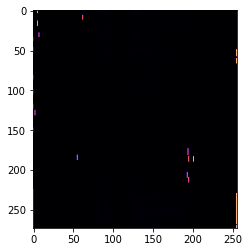

In [31]:
image = np.uint8(positive_sample_images[0])
thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

# remove horizontal lines
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (25, 1))
detected_lines = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv.findContours(detected_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv.drawContours(image, [c], -1, (255, 255, 255), 1)

# Fill in vertical gaps
repair_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,6))
result = 255 - cv.morphologyEx(255 - image, cv.MORPH_CLOSE, repair_kernel, iterations=1)

plt.imshow(result, cmap=plt.get_cmap('magma'))

In [12]:
image.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'